Classification of 311 data: invalid cases

# Invalid Cases

`Status_Notes` contains 'case invalid' or 'case is invalid'

`Responsible_Agency` must contain '311 Supervisor Queue'

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# import matplotlib as mpl
import seaborn as sns
import os

# import statsmodels.formula.api as smf
# import statsmodels.tsa.api as smt
# import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# # sns.set()
# sns.set_style("darkgrid")
# # sns.set_style("whitegrid")

# from cycler import cycler

# # SVDS colors
# # colors = ['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#ECEFF0','#FF9700', '#091D32']

# n = 20 # Number of colors
# #colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
# #colors = [plt.get_cmap('Set1')(1. * i/n) for i in range(n)]
# # set up some plotting defaults
# #plt.rcParams['axes.prop_cycle'] = cycler('color', colors)
# plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['font.size'] = 16
# plt.rcParams['xtick.labelsize'] = 14
# plt.rcParams['ytick.labelsize'] = 14
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.labelcolor'] = '#677385'
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['lines.color'] = '#0055A7'
# plt.rcParams['lines.linewidth'] = 1.5
# plt.rcParams['text.color'] = '#677385'
# plt.rcParams['legend.fontsize'] = 16
# # plt.rcParams['axes.formatter.limits'] = -10, 10

# plt.rcParams.update()

# # # ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
# # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# np.set_printoptions(precision=5, suppress=True)
# pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

In [3]:
# infile = os.path.join(os.getenv('HOME'),'Desktop', '311', 'calls_census_tracts.csv')
# df = pd.read_csv(infile, header=0, index_col=0, parse_dates=[1, 2, 3])

In [4]:
# outfile = os.path.join(os.getenv('HOME'),'Desktop', '311', 'calls_census_tracts.p')
# df.to_pickle(outfile)

In [5]:
infile = os.path.join(os.getenv('HOME'),'Desktop', '311', 'calls_census_tracts.p')
df = pd.read_pickle(infile)

In [6]:
df.shape

(1594511, 23)

In [7]:
df.columns = [x.replace('.', '_') for x in df.columns]
df = df.drop(['Point', 'Media_URL', 'shape_area', 'shape_len', 'optional'], axis=1)

df['Status_Notes'] = df['Status_Notes'].astype('str').apply(lambda x: x.lower())

Status_Notes
"case invalid"
"case is invalid"

Responsible_Agency
"311 Supervisor Queue"

In [8]:
# only include the cases with Responsible_Agency = '311 Supervisor Queue'
df['invalid'] = df['Status_Notes'].apply(lambda x: x.find('case') >= 0) & df['Status_Notes'].apply(lambda x: x.find('invalid') >= 0) & (df['Responsible_Agency'] == '311 Supervisor Queue')

# Investigate invalid requests

In [9]:
# remove duplicates

# TODO: may want to only exclude those that contain the string 'duplicate'

df = df[~df['Status_Notes'].apply(lambda x: x.find('dup') >= 0)]

In [10]:
print('From {} to {}:'.format(df['Opened'].min(), df['Opened'].max()))
print('{:,} / {:,} cases are invalid ({:.1f}%)'.format(df['invalid'].sum(), df.shape[0], (df['invalid'].sum()/df.shape[0])*100))

From 2008-03-20 11:48:32 to 2016-03-16 00:55:50:
5,698 / 1,560,165 cases are invalid (0.4%)


## Count of invalid cases

In [11]:
df[df['invalid']]['Category'].value_counts()

Blocked Street or SideWalk      1329
Street and Sidewalk Cleaning    1211
Graffiti Public Property         977
General Requests                 444
Sign Repair                      301
Rec and Park Requests            222
Litter Receptacles               177
Illegal Postings                 156
Graffiti Private Property        146
Damaged Property                 135
Streetlights                     133
Sidewalk or Curb                 130
Street Defects                    94
Tree Maintenance                  85
Sewer Issues                      62
Temporary Sign Request            32
Noise Report                      25
Residential Building Request      13
Abandoned Vehicle                 12
MUNI Feedback                      9
Catch Basin Maintenance            3
Construction Zone Permits          1
311 External Request               1
Name: Category, dtype: int64

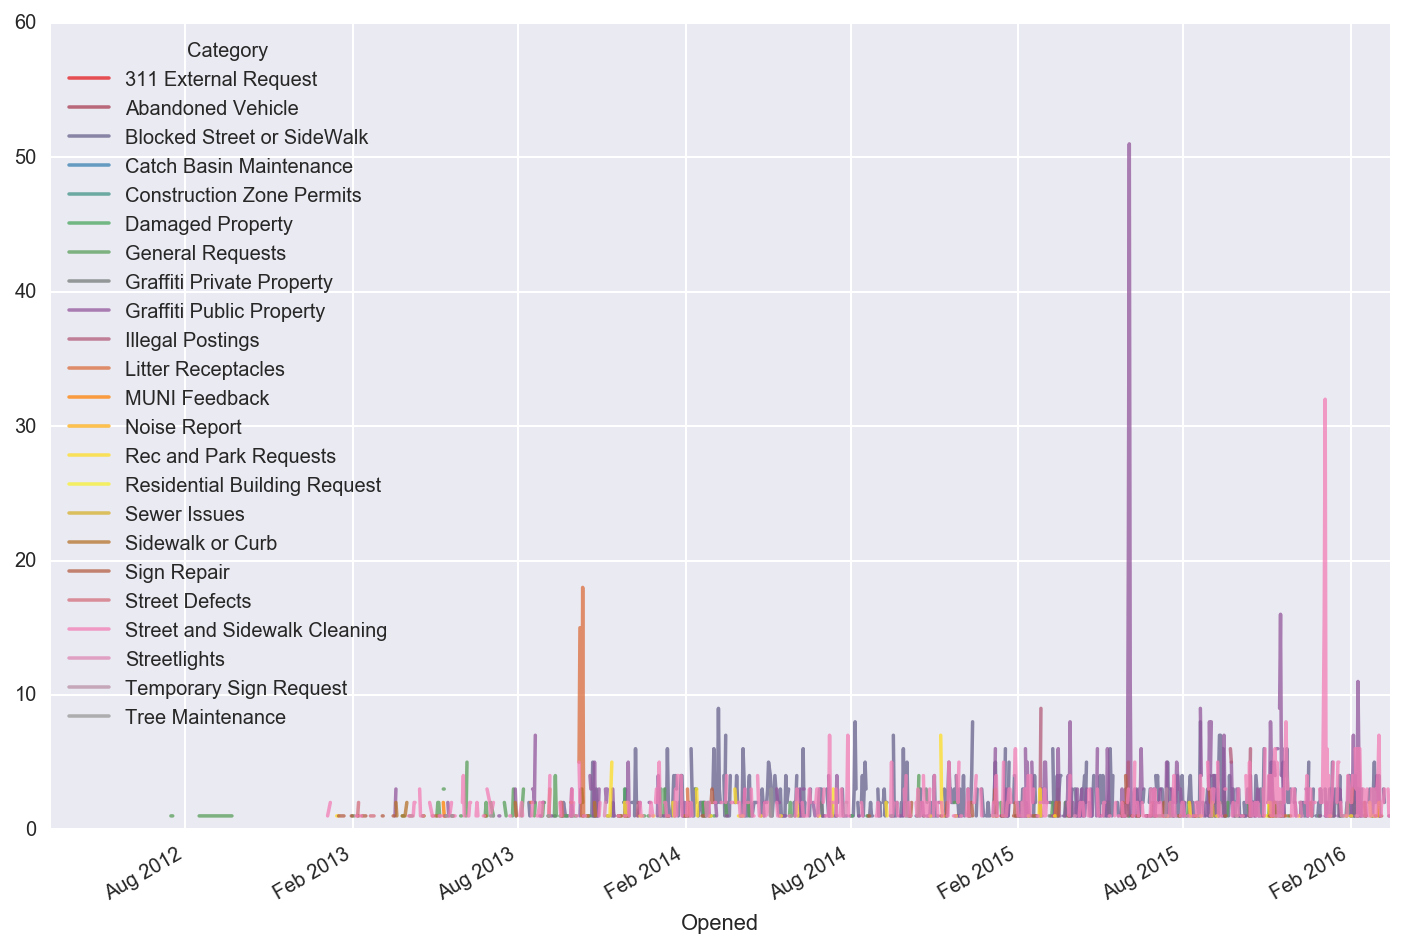

In [12]:
# category over time
fix, ax = plt.subplots(figsize=(12, 8));
colormap='Set1'
df[df['invalid']].reset_index().set_index('Opened').groupby(by=[pd.TimeGrouper('1D'), 'Category'])['Category'].count().unstack().plot(ax=ax, colormap=colormap, alpha=.75);

In [13]:
df[df['invalid']]['nhood'].value_counts()

Mission                           933
South of Market                   387
Castro/Upper Market               305
Financial District/South Beach    291
Hayes Valley                      282
Tenderloin                        262
Sunset/Parkside                   251
Bayview Hunters Point             238
Haight Ashbury                    187
Russian Hill                      170
Excelsior                         167
Bernal Heights                    152
Outer Richmond                    151
West of Twin Peaks                149
Outer Mission                     138
Nob Hill                          130
Oceanview/Merced/Ingleside        119
North Beach                       111
Mission Bay                        94
Inner Richmond                     93
Potrero Hill                       92
Pacific Heights                    90
Inner Sunset                       90
Lone Mountain/USF                  83
Chinatown                          81
Western Addition                   79
Marina      

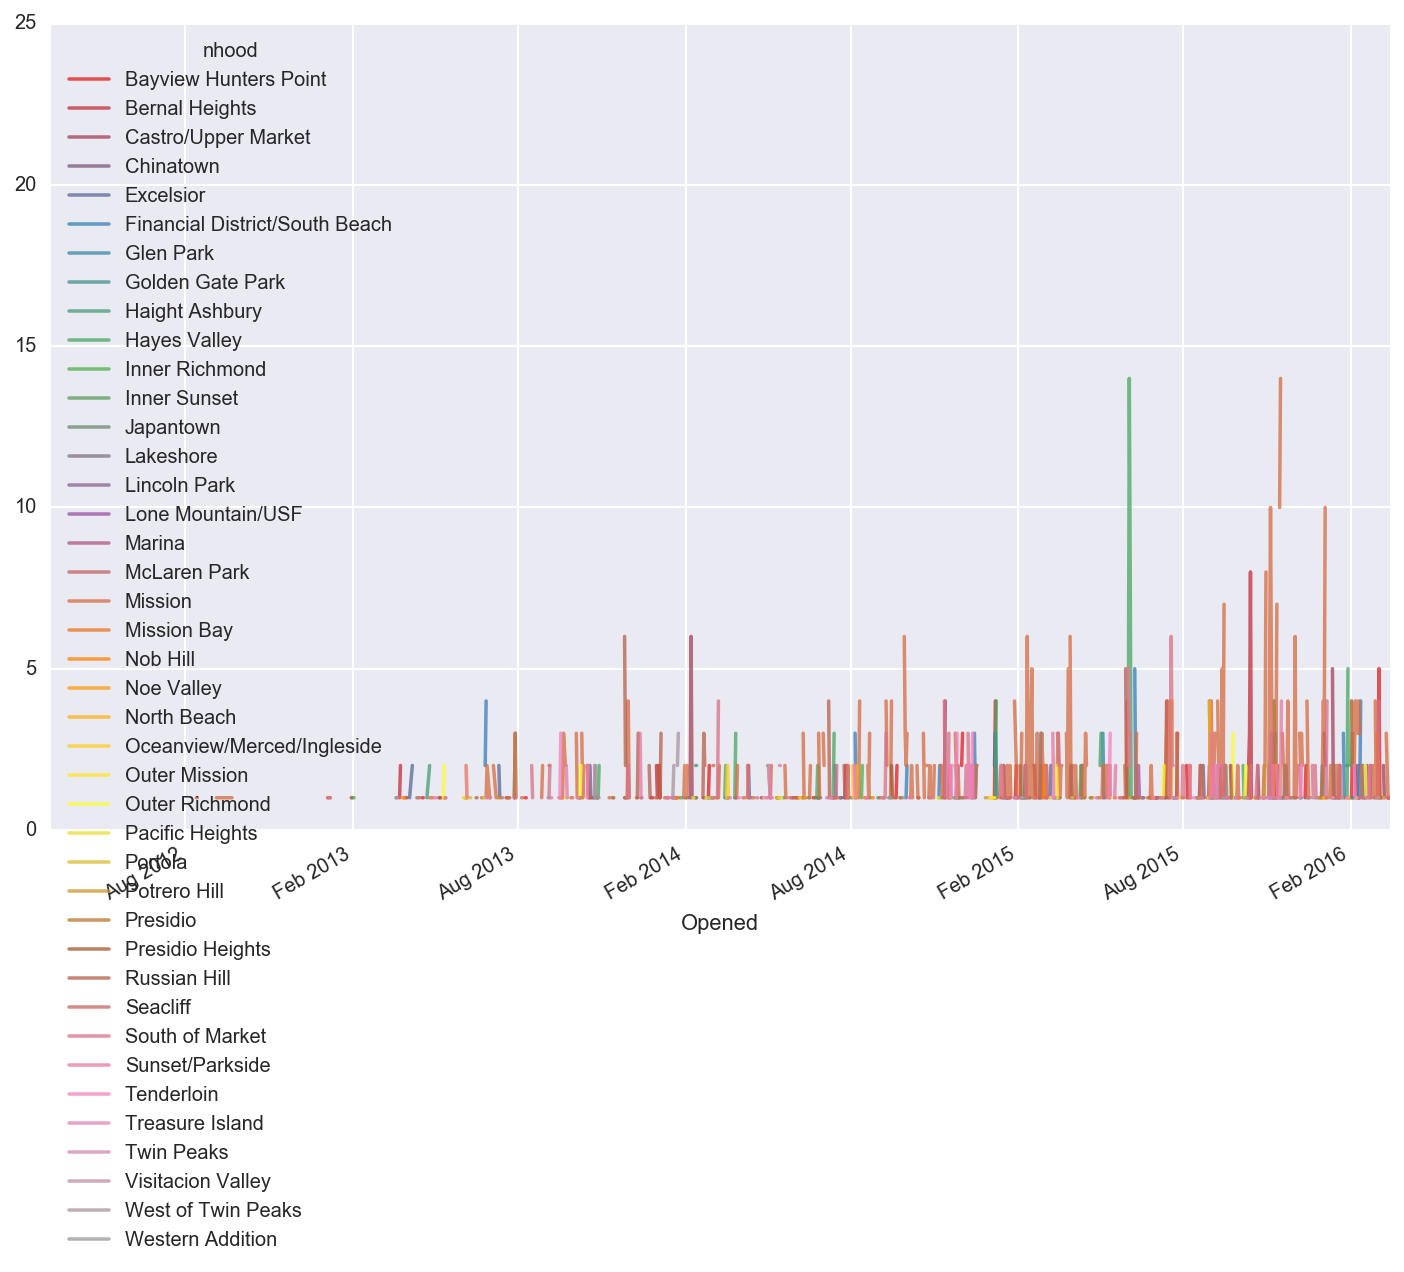

In [14]:
# nhood over time
fix, ax = plt.subplots(figsize=(12, 8));
colormap='Set1'
df[df['invalid']].reset_index().set_index('Opened').groupby(by=[pd.TimeGrouper('1D'), 'nhood'])['nhood'].count().unstack().plot(ax=ax, colormap=colormap, alpha=.75);

## Look at reasons for being invalid

In [15]:
prop_to_print = .01
# 1% of cases = ~57

samp = df[df['invalid']].sample(frac=prop_to_print, replace=False, random_state=42)

for caseid, reason in samp.reset_index()[['CaseID', 'Status_Notes']].values:
    print('{}: {}'.format(caseid, reason))

5086038: case is invalid - if this issue is still in progress, please contact parking & traffic enforcement at 415-553-1200, press 1, then 7.
5335770: case is invalid - not enough information -
3270059: case is invalid - please report this incident to dept. parking/traffic by calling (415) 553-1200
5082949: case is invalid - incomplete location , no contact info
4614512: case is invalid - usps
5275025: case is invalid - plz see notes
5022242: case is invalid - no enforcement of graffiti on recology bins
4993108: case is invalid - address is invalid
4569716: case is invalid - see notes
2919510: case is invalid -
5237481: case is invalid - please call sfpd - 415-553-1200
3621546: case is invalid - private sign bsm 415-554-5810
5287812: case is invalid - invalid sr new sr# 5287837
3718398: case is invalid - customer needs to contact dpt- 415-553-1200
4284091: case is invalid -
3217543: case is invalid - city of oakland location
5481253: case is invalid -
5183367: case is invalid - please 

In [16]:
df.ix[5175003]

Opened                                               2015-10-09 13:00:00
Closed                                               2015-10-09 20:13:25
Updated                                              2015-10-09 20:13:25
Status                                                            Closed
Status_Notes           case is invalid - please provide more detail o...
Responsible_Agency                                  311 Supervisor Queue
Category                                        Graffiti Public Property
Request_Type                       Offensive Graffiti on Public Property
Request_Details         Other_enter_additional_details_below - Offensive
Address                           Intersection of GEARY BLVD and LYON ST
Supervisor_District                                                    2
Neighborhood                                       Lower Pacific Heights
Source                                                  Web Self Service
nhood                                              

In [17]:
df.ix[3420105]

Opened                                               2014-03-03 15:49:12
Closed                                               2014-03-03 16:23:21
Updated                                              2014-03-03 16:23:21
Status                                                            Closed
Status_Notes           case is invalid - per notes, sr is only a test...
Responsible_Agency                                  311 Supervisor Queue
Category                                              Litter Receptacles
Request_Type                                          Cans_Left_Out_24x7
Request_Details                                                      NaN
Address                   1 SOUTH VAN NESS AVE, SAN FRANCISCO, CA, 94103
Supervisor_District                                                    6
Neighborhood                                             South of Market
Source                                                  Web Self Service
nhood                                              

# More investigation

In [18]:
# time features
df['hour_of_day'] = df['Opened'].apply(lambda x: x.strftime('%H')).astype(int)
df['day_of_week'] = df['Opened'].apply(lambda x: x.dayofweek)
df['month'] = df['Opened'].apply(lambda x: x.month)

## Time of day for valid and invalid requests

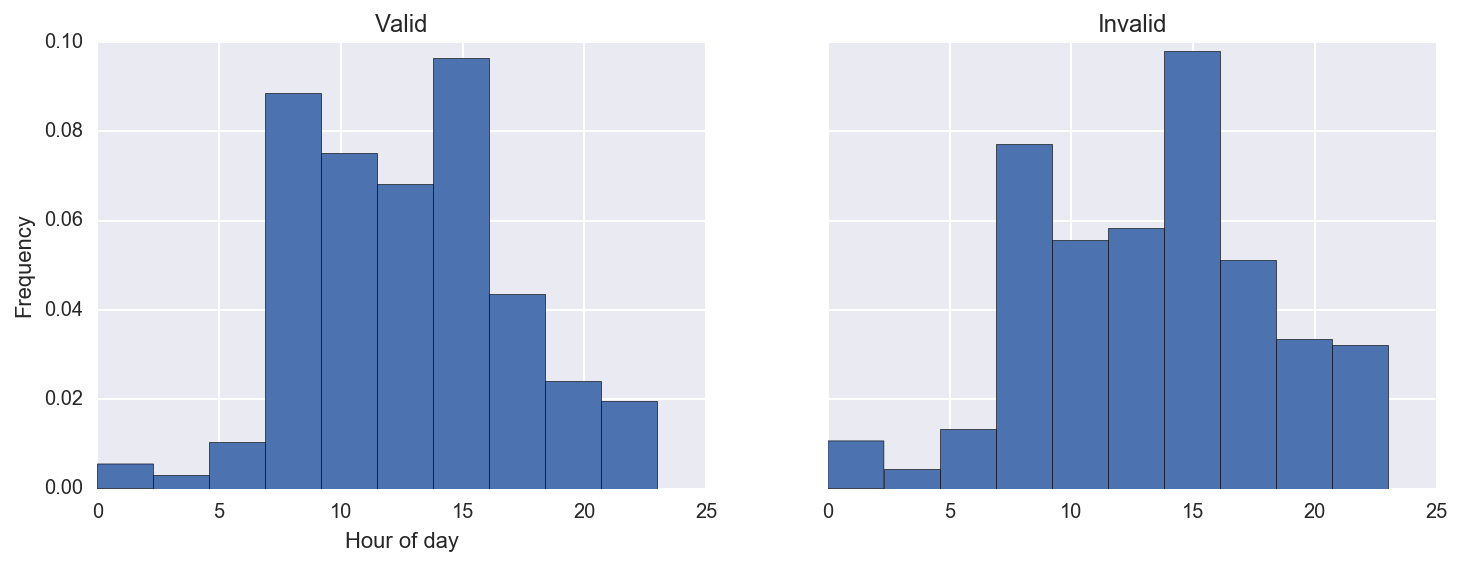

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True);
# df_valid_samp['Opened'].apply(lambda x: x.strftime('%H')).astype(int).plot(ax=ax1, kind='hist', normed=True);
df[~df['invalid']]['hour_of_day'].plot(ax=ax1, kind='hist', normed=True);
df[df['invalid']]['hour_of_day'].plot(ax=ax2, kind='hist', normed=True);
ax1.set_title('Valid');
ax2.set_title('Invalid');
ax1.set_xlabel('Hour of day');

## Day of week for valid and invalid requests

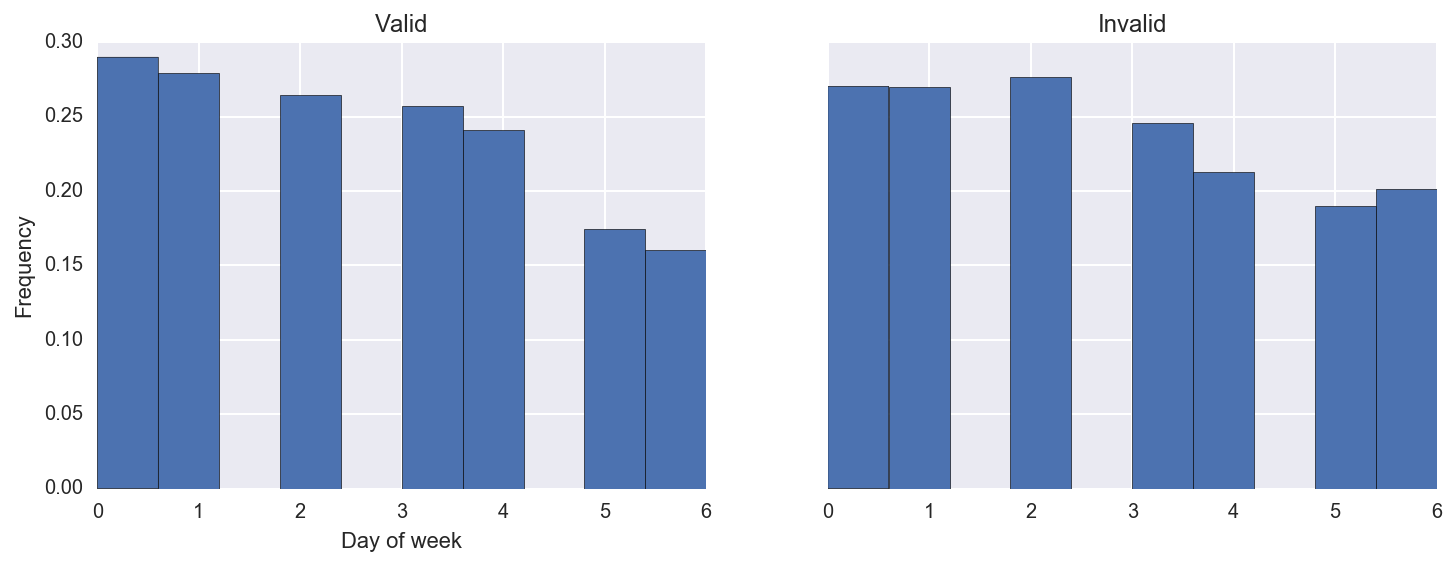

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True);
df[~df['invalid']]['day_of_week'].plot(ax=ax1, kind='hist', normed=True);
df[df['invalid']]['day_of_week'].plot(ax=ax2, kind='hist', normed=True);
ax1.set_title('Valid');
ax2.set_title('Invalid');
ax1.set_xlabel('Day of week');

## Month

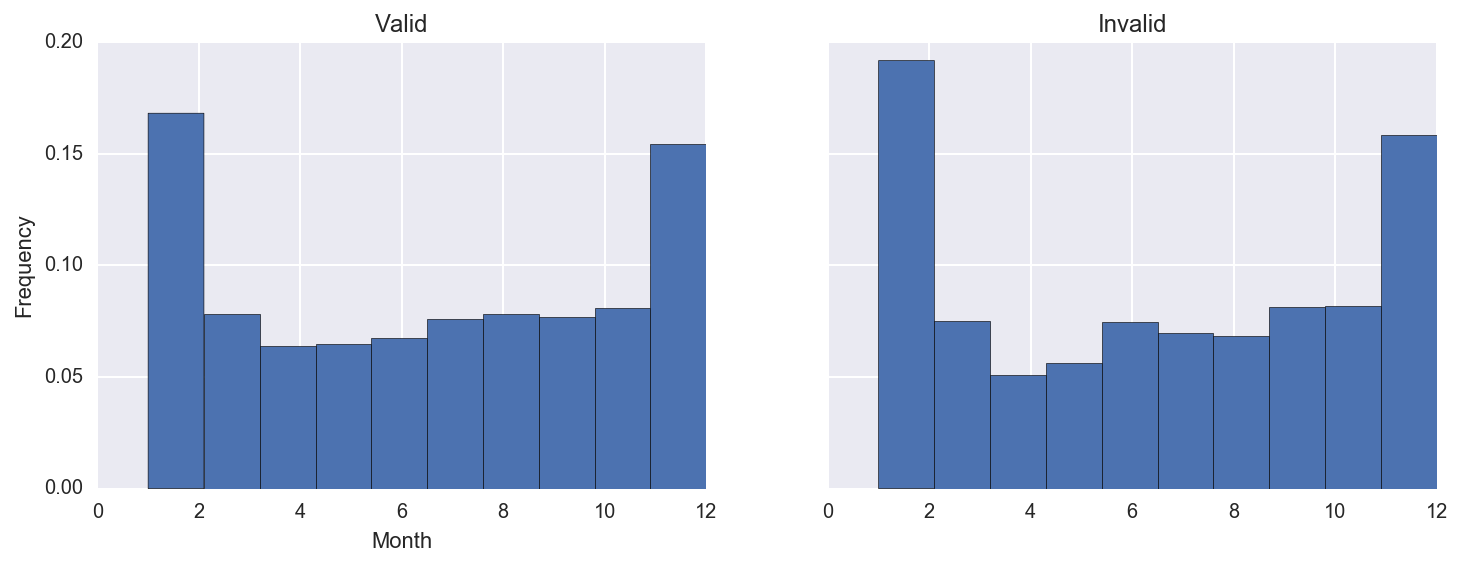

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True);
df[~df['invalid']]['month'].plot(ax=ax1, kind='hist', normed=True);
df[df['invalid']]['month'].plot(ax=ax2, kind='hist', normed=True);
ax1.set_title('Valid');
ax2.set_title('Invalid');
ax1.set_xlabel('Month');

## Neighborhood

In [30]:
df_inv = df[df['invalid']]
# get a sample of valid cases the same size as the invalid cases
df_valid_samp = df[~df['invalid']].sample(n=df_inv.shape[0], replace=False)

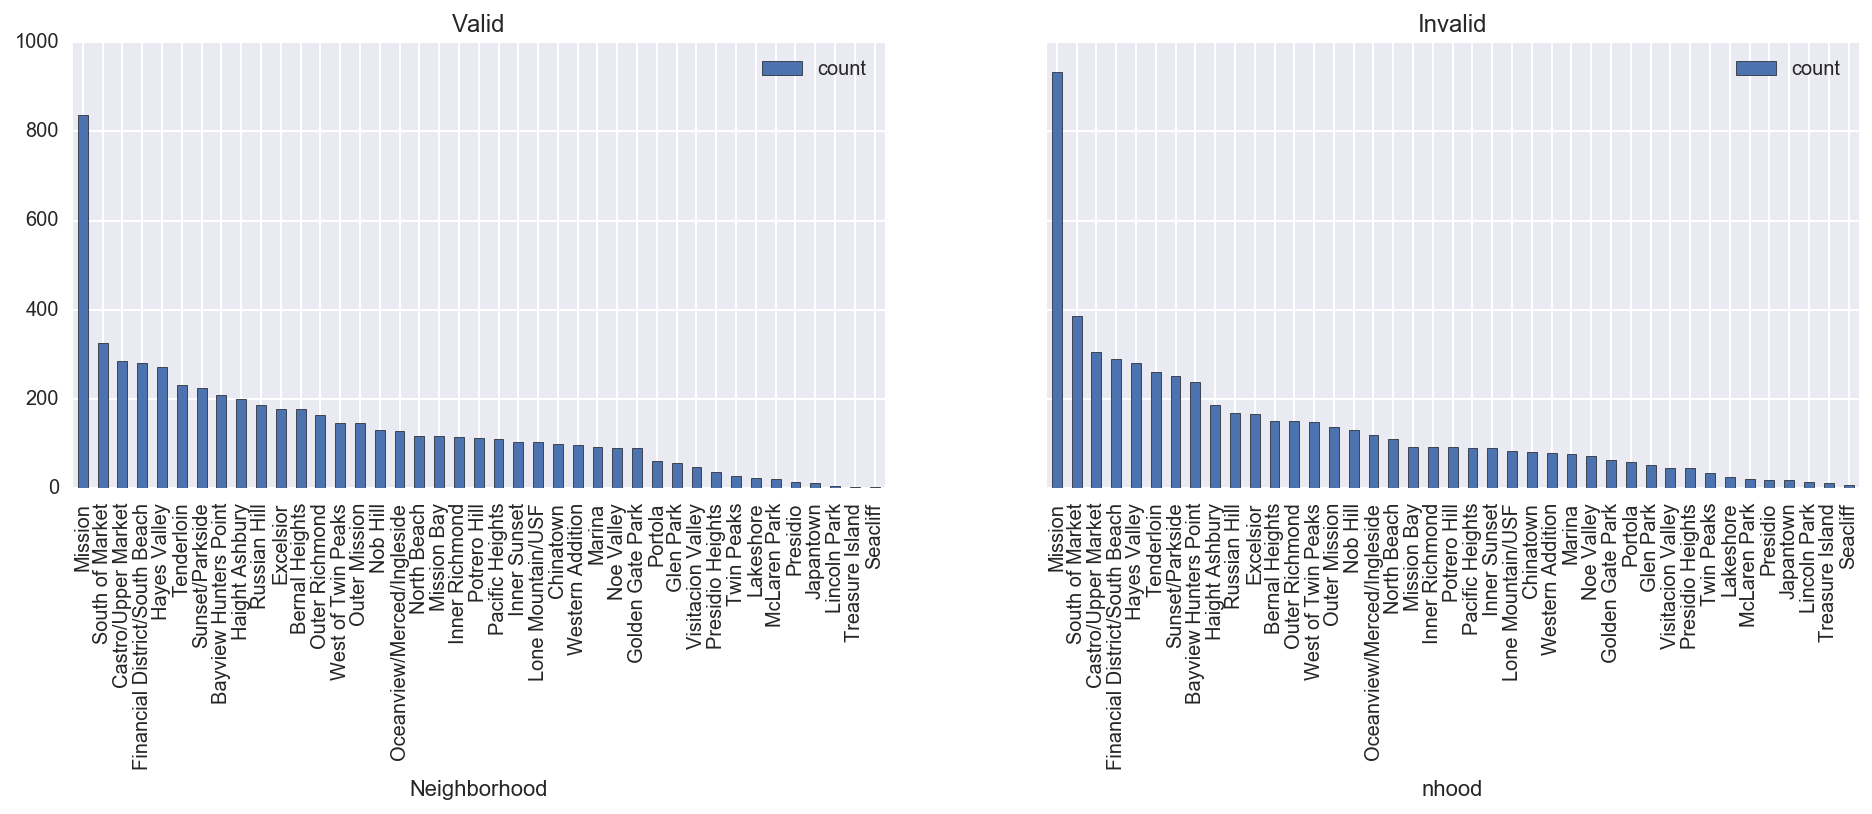

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True, sharey=True);

df_valid_samp.groupby(by=['nhood'])[['nhood']].count().rename(columns={'nhood':'count'}).sort_values('count', ascending=False).plot(ax=ax1, kind='bar');
df_inv.groupby(by=['nhood'])[['nhood']].count().rename(columns={'nhood':'count'}).sort_values('count', ascending=False).plot(ax=ax2, kind='bar');

# df[~df['invalid']].groupby(by=['nhood'])[['nhood']].count().rename(columns={'nhood':'count'}).sort_values('count', ascending=False).plot(ax=ax1, kind='bar');
# df[df['invalid']].groupby(by=['nhood'])[['nhood']].count().rename(columns={'nhood':'count'}).sort_values('count', ascending=False).plot(ax=ax2, kind='bar');

ax1.set_title('Valid');
ax2.set_title('Invalid');
ax1.set_xlabel('Neighborhood');

In [24]:
def calc_prop(df,
              group_field,
              time_field = 'Opened',
              inv_field = 'invalid',
              inv_c_field = 'invalid_count',
              c_field = 'total_count',
              dest_field = 'prop_inv',
              ):
    '''Calculate the proportion of invalid reports for a particular dimension
    e.g.,
    group_field = 'nhood'
    group_field = 'Category'
    group_field = 'Request_Type'
    group_field = 'Responsible_Agency'
    group_field = 'tractce10'
    group_field = 'hour_of_day'
    group_field = 'day_of_week'
    group_field = 'month'
    '''

    df_count_inv = df[df[inv_field]].groupby(by=group_field)[[time_field]].count().rename(columns={time_field: inv_c_field})
    df_prop = df.groupby(by=group_field)[[time_field]].count().rename(columns={time_field: c_field})
    df_prop = df_prop.merge(df_count_inv, how='left', left_index=True, right_index=True)
    df_prop[dest_field] = (df_prop[inv_c_field] / df_prop[c_field]).fillna(0)
    return df_prop

In [25]:
def avg_by_time(df,
                group_field,
                time_length = 'D',
                time_field = 'Opened',
                inv_field = 'invalid',
                inv_c_field = 'invalid_count',
                field_to_count = 'CaseID',
                dest_field = 'avg_n_inv',
                ):
    '''Calculate the average number of invalid reports that occur per time length (e.g., day, week).
    For more time codes, see: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    Uses the full date range of the input dataframe df (fills null days with 0).
    
    e.g.,
    group_field = 'nhood'
    group_field = 'Category'
    group_field = 'Request_Type'
    group_field = 'Responsible_Agency'
    group_field = 'tractce10'
    '''
    
    # todo: handle group_field as a list
    
    df_count_inv = df[df[inv_field]].reset_index().set_index(time_field).groupby(by=[pd.TimeGrouper('1D'), group_field, inv_field], as_index=True)[[field_to_count]].count()
    df_count_inv = df_count_inv.reset_index().set_index(time_field)[[group_field, field_to_count]].rename(columns={field_to_count: inv_c_field})

    start_date = pd.Timestamp(df[time_field].min().strftime('%Y-%m-%d'))
    end_date = pd.Timestamp(df[time_field].max().strftime('%Y-%m-%d'))
    
    # reindex to fill in any missing dates
    df_piv = df_count_inv.pivot(columns=group_field).reindex(index=pd.date_range(start_date, end_date)).fillna(0)
    df_piv.index.name = time_field

    df_count_inv = pd.melt(df_piv.reset_index(), id_vars=time_field, value_vars=inv_c_field, value_name=inv_c_field).set_index(time_field)[[group_field, inv_c_field]]
    
    # calculate average per time_length
    df_count_inv = df_count_inv.groupby(by=group_field).resample(time_length).sum()
    df_avg_inv = df_count_inv.reset_index().groupby(by=group_field)[[inv_c_field]].mean()
    df_avg_inv = df_avg_inv.rename(columns={inv_c_field: dest_field})
    
    return (df_count_inv, df_avg_inv)

In [26]:
# Work with a 10% sample

# random_state = 42
# # random_state = None

# df_samp = df.sample(frac=0.1, replace=False, random_state=random_state)

# print(df_samp.shape)

# print(df_samp['invalid'].mean())
# print(df['invalid'].mean())

# print(df[df['invalid']]['Opened'].min())
# print(df[df['invalid']]['Opened'].max())

# print(df_samp[df_samp['invalid']]['Opened'].min())
# print(df_samp[df_samp['invalid']]['Opened'].max())

In [27]:
# Proportion of invalid cases

group_field = 'nhood'
# group_field = 'Category'
# group_field = 'Request_Type'
# group_field = 'Responsible_Agency'
# group_field = 'tractce10'
# group_field = 'hour_of_day'
# group_field = 'day_of_week'
# group_field = 'month'

df_prop = calc_prop(df, group_field)
print(df_prop.sort_values(by='prop_inv', ascending=False))

                                total_count  invalid_count  prop_inv
nhood                                                               
Presidio                                754             20  0.026525
Treasure Island                         611             13  0.021277
Lincoln Park                           1119             15  0.013405
Mission Bay                           10903             94  0.008621
Russian Hill                          26802            170  0.006343
Financial District/South Beach        48126            291  0.006047
McLaren Park                           4034             22  0.005454
Lakeshore                              4604             25  0.005430
Castro/Upper Market                   56823            305  0.005368
South of Market                       80259            387  0.004822
Hayes Valley                          61821            282  0.004562
Golden Gate Park                      14170             64  0.004517
Outer Mission                     

In [28]:
# Proportion of invalid cases by category

df_prop = calc_prop(df, 'Category')
print(df_prop.sort_values(by='prop_inv', ascending=False))

                              total_count  invalid_count  prop_inv
Category                                                          
Blocked Street or SideWalk          12091         1329.0  0.109916
Construction Zone Permits              19            1.0  0.052632
Noise Report                         1156           25.0  0.021626
Sign Repair                         28664          301.0  0.010501
Rec and Park Requests               25779          222.0  0.008612
Graffiti Public Property           150666          977.0  0.006485
Sidewalk or Curb                    24148          130.0  0.005383
Illegal Postings                    29653          156.0  0.005261
Litter Receptacles                  33649          177.0  0.005260
General Requests                    94239          444.0  0.004711
Streetlights                        41648          133.0  0.003193
Street Defects                      34338           94.0  0.002737
Street and Sidewalk Cleaning       554045         1211.0  0.00

In [29]:
# Average number of reports by time window (e.g., per day by neighborhood)

group_field = 'nhood'
# group_field = 'Category'
# group_field = 'Request_Type'
# group_field = 'Responsible_Agency'
# group_field = 'tractce10'

time_length = 'D'
# time_length = 'W'
# time_length = 'M'

df_count_inv, df_avg_inv = avg_by_time(df, group_field, time_length=time_length)
print(df_avg_inv.sort_values(by='avg_n_inv', ascending=False))

                                avg_n_inv
nhood                                    
Mission                          0.319630
South of Market                  0.132580
Castro/Upper Market              0.104488
Financial District/South Beach   0.099692
Hayes Valley                     0.096608
Tenderloin                       0.089757
Sunset/Parkside                  0.085988
Bayview Hunters Point            0.081535
Haight Ashbury                   0.064063
Russian Hill                     0.058239
Excelsior                        0.057211
Bernal Heights                   0.052073
Outer Richmond                   0.051730
West of Twin Peaks               0.051045
Outer Mission                    0.047276
Nob Hill                         0.044536
Oceanview/Merced/Ingleside       0.040767
North Beach                      0.038027
Mission Bay                      0.032203
Inner Richmond                   0.031860
Potrero Hill                     0.031518
Pacific Heights                  0